# Use Sagemaker trained model locally

Download pretrained model from sagemaker

In [1]:

!aws s3 cp "s3://sagemaker-us-east-1-348831852500/mxnet-training-2020-03-30-09-24-14-314/output/model.tar.gz"  TRAINEDMODEL/.


download: s3://sagemaker-us-east-1-348831852500/mxnet-training-2020-03-30-09-24-14-314/output/model.tar.gz to TRAINEDMODEL/model.tar.gz


Unzip the content of Sagemaker trained model

In [2]:
!cd TRAINEDMODEL/.;tar -zxvf model.tar.gz

unet_RGB.params
unet_RGB_learning_curve_data.npy


Cross check model stats saved during training process

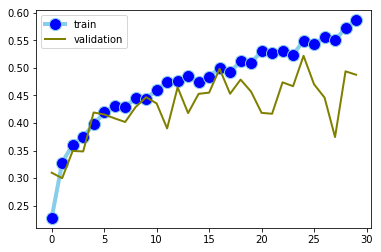

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

learning_curve=np.load("TRAINEDMODEL/unet_RGB_learning_curve_data.npy")
epochs=len(learning_curve.item(0)['train'])
# Data
df=pd.DataFrame({'x': range(0,epochs), 'train': learning_curve.item(0)['train'], 'validation': learning_curve.item(0)['val'] })
 
# multiple line plot
plt.plot( 'x', 'train', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'validation', data=df, marker='', color='olive', linewidth=2)
plt.legend()


## Testing model locally

In [4]:
import sys
from os import path
import mxnet as mx
sys.path.append("./src")
import unet


def model_fn(model_dir):
    """function used to load pretrained model"""
    ctx =  mx.cpu()
    net = unet.Unet()
    print ("Loading", model_dir)
    if path.exists(model_dir+"/unet_RGB.params"):
        print ("Loading RGB Model")
        net.load_params(model_dir+"/unet_RGB.params", ctx)
        print ("RGB Model Loaded")
        
    elif path.exists(model_dir+"/unet_ALL_BANDS.params"):
        print ("Loading ALL_BANDS Model")
        net.load_params(model_dir+"/unet_ALL_BANDS.params", ctx)
        print ("ALL_BANDS Model Loaded")
        
    else:
        print ("Model Missing")
        net=None
    return (net)

In [5]:

trainedUnet=model_fn('./TRAINEDMODEL')

Loading ./TRAINEDMODEL
Loading RGB Model
RGB Model Loaded


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:428: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


### Utility functions

In [6]:
import mxnet as mx
import mxnet.ndarray as nd
import logging
import math

class BatchLoader:
    def __init__(self, images, batch_size, ctx, multisp):
        """
        Class to load all images from the given folders
        :param images: list of images
        :param batch_size: int number of images per batch
        :param ctx: mx.gpu(n) or mx.cpu()
        :param multisp: boolean (multispectral) If true, images will be read from .npy files,
                        and only the first 3 bands will be used for cloud classification.
        """
        self.ctx = ctx
        self.batch_size = batch_size
        self.images = []
        self.multisp = multisp

        self.images=images

        if self.images:
            self.channels, self.imgsize, _ = self._read_img(self.images[0]['data']).shape

        logging.info("Found a total of {} images".format(len(self.images)))

    def __len__(self):
        return len(self.filenames)

    def _preprocess(self, data):
        data = nd.array(data).astype('float32').as_in_context(self.ctx)
        if not self.multisp:
            data = data / 255
            data = nd.transpose(data, (2, 0, 1))
        return data

    def _read_img(self, img):
        return self._preprocess(img)

    def _load_batch(self, images):
        batch = mx.nd.empty((len(images), self.channels, self.imgsize, self.imgsize), self.ctx)
        for idx, fn in enumerate(images):
            batch[idx] = self._read_img(fn['data'])
        return batch

    def get_batches(self):
        for n in range(int(math.ceil(len(self.images)/self.batch_size))):
            if (n + 1) * self.batch_size <= len(self.images):
                files_batch = self.images[n * self.batch_size:(n + 1) * self.batch_size]
            else:
                files_batch = self.images[n * self.batch_size:]

            yield self._load_batch(files_batch)

### Loop on files and plot images

In [11]:
#Load Validation data and related masks
from PIL import Image
import os
import glob
import numpy as np
import ntpath

files = glob.glob(os.path.join('./data/rgb/test/', '*' + '.png'))
images=[]
masks=[]
decode_year={'2016': 'ttl1904', '2017': 'ttl1905'}
i=0
for file in files:
    #Load Image
    #print (file)
    image = Image.open(file)
    image_data = np.array(image.getdata())
    image_data=image_data.reshape(256,256,3)
    images.append ({'data':image_data})
    #Load Label
    filename=ntpath.basename(file)
    parts=filename.split('_')
    year=parts[3][0:4]
    mask_file="./data/masks/{}_{}_geopedia_{}.png".format(parts[0],parts[1],decode_year[year])
    print ("Mask:",mask_file)
    image = Image.open(mask_file)
    image_data = np.asarray(image)
    masks.append ({'data':image_data})
    i=i+1
    if i>5: 
        break    

Mask: ./data/masks/tulip_ddda8740f5be4e42419788408ecd4e42_geopedia_ttl1904.png
Mask: ./data/masks/tulip_6ea87d400c0b4d4236217f40c8194d42_geopedia_ttl1905.png
Mask: ./data/masks/tulip_08e88f40a40f51426ca490400d1e5142_geopedia_ttl1904.png
Mask: ./data/masks/tulip_512780400c0b4d42b5e38040c8194d42_geopedia_ttl1905.png
Mask: ./data/masks/tulip_4bd2bb405a9b5242af8ebc40a3a95242_geopedia_ttl1905.png
Mask: ./data/masks/tulip_c38786409b004f42274487402f0f4f42_geopedia_ttl1904.png


In [12]:
import mxnet as mx
from SM_inference import BatchLoader
img_short=images[1:3]

ctx =   mx.cpu()
loader=BatchLoader(images,64,ctx,False)

NOT SELF MULTISP


In [13]:
predictions=[]
for idxb, batch in enumerate(loader.get_batches()):
    #print (batch.shape)
    preds = nd.argmax(trainedUnet(batch), axis=1)
    for pred in preds:
        predictions.append(pred)
    break  


NOT SELF MULTISP
NOT SELF MULTISP
NOT SELF MULTISP
NOT SELF MULTISP
NOT SELF MULTISP
NOT SELF MULTISP


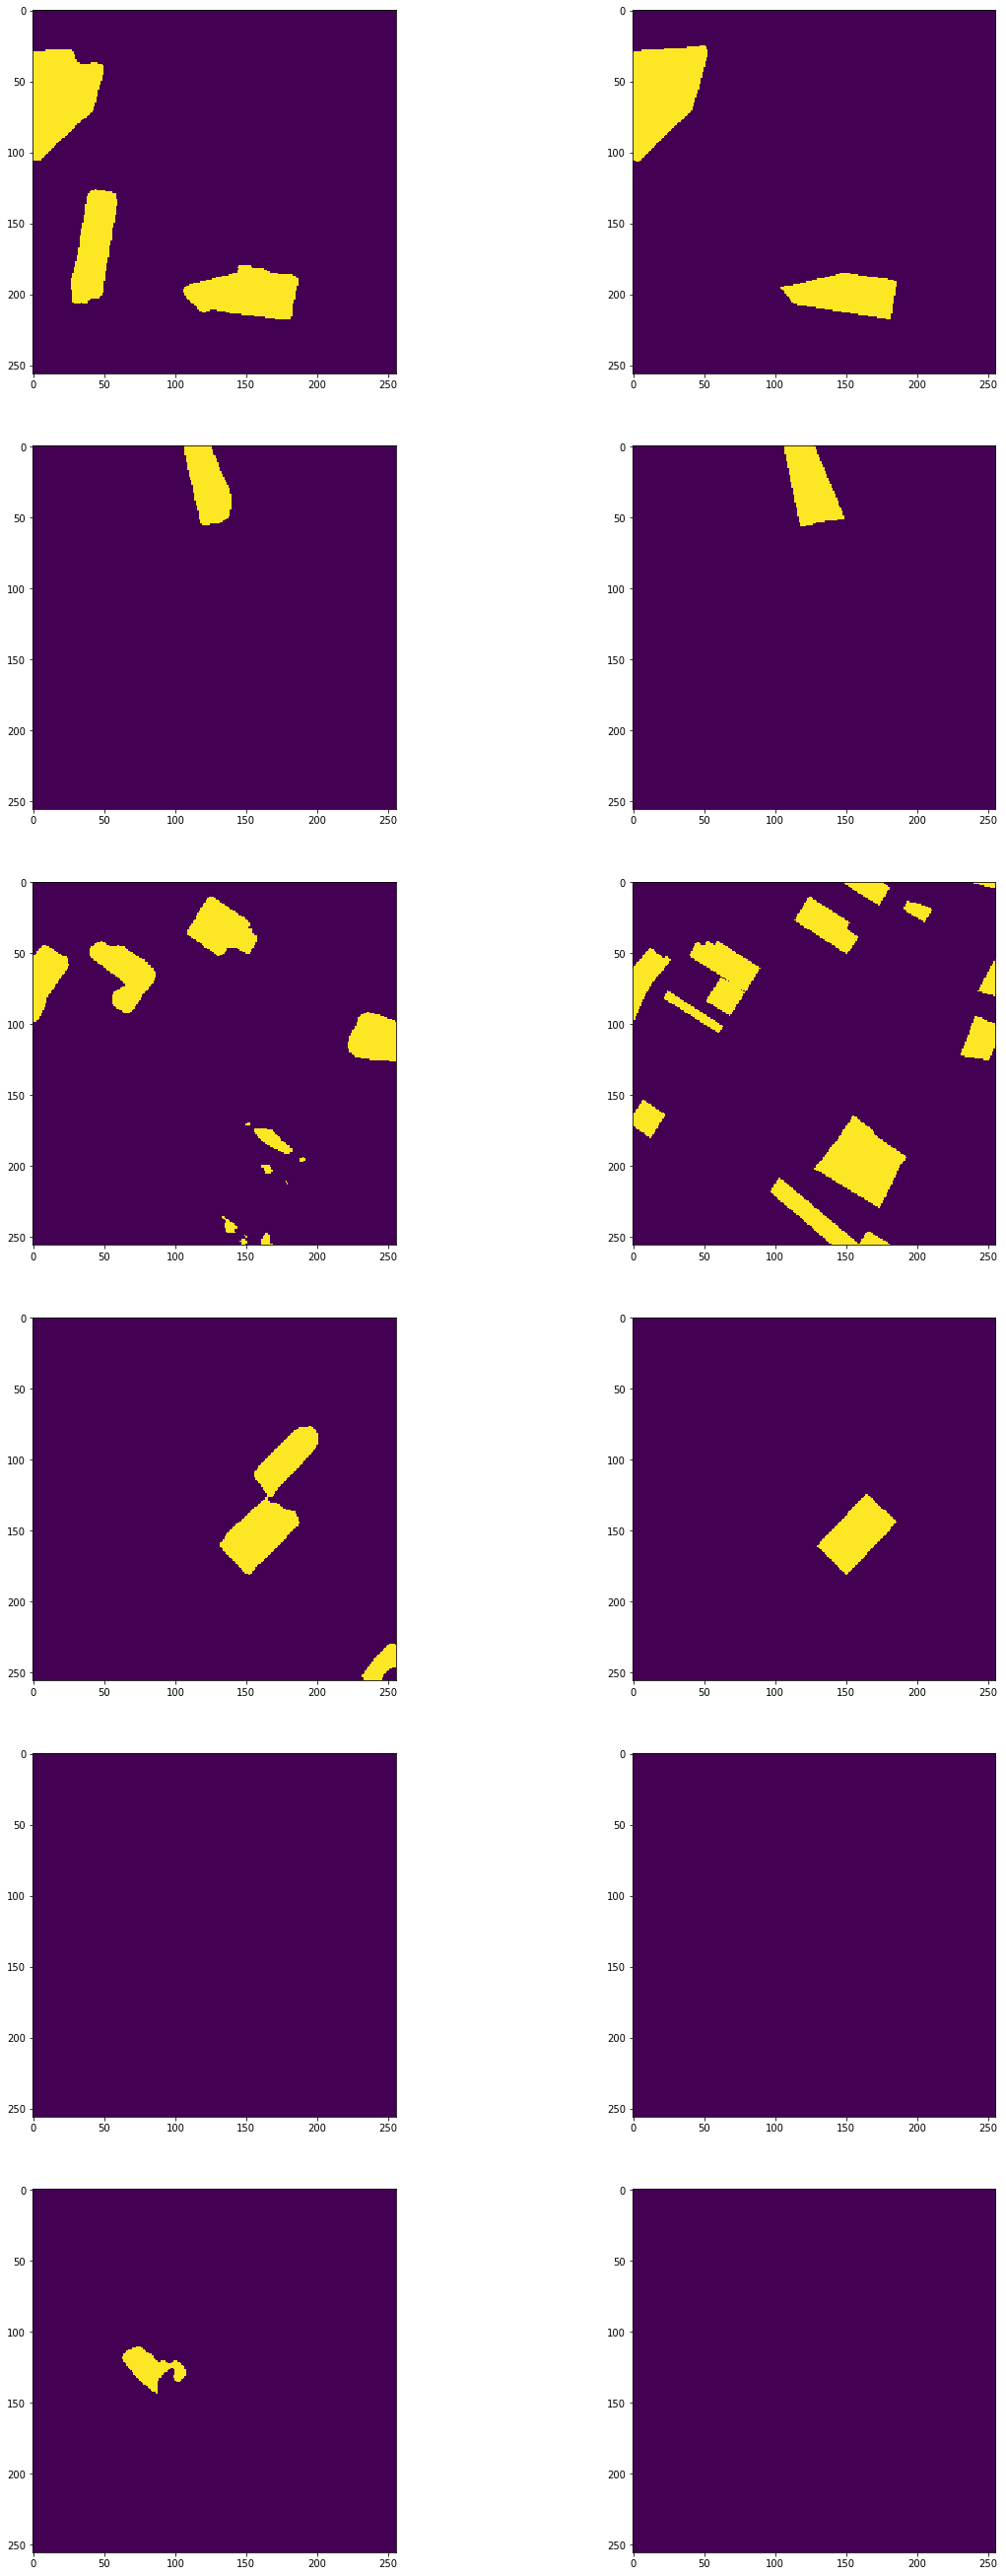

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt
import PIL
from PIL import Image

#plt.rcParams['figure.figsize'] = [20, 20]
fig=plt.figure(figsize=(20, 80))
cols=2
rows=10
ax=[]
i=0
for pred,mask in zip (predictions,masks):
    i=i+1
    img=Image.fromarray(pred.asnumpy())
    ax.append( fig.add_subplot(rows, cols, i) )
    plt.imshow(img)
    i+=1
    #print (np.array(mask['data']))
    img=Image.fromarray(np.array(mask['data']),'L')
    ax.append( fig.add_subplot(rows, cols, i) )
    plt.imshow(img)
    